# 불균형 데이터 처리

- 2013년 유럽의 신용카드 사용 내역 (2일간)
- 불균형 데이터 처리
 - SMOTE
 - RandomOverSampler
 - ADASYN

# 데이터
## import

In [74]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [75]:
# !pip install imblearn

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, roc_auc_score
from sklearn.metrics import plot_precision_recall_curve,precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

- 데이터 다운로드 66M

In [4]:
!curl -L https://bit.ly/2nweJrO -o credit.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   147  100   147    0     0     34      0  0:00:04  0:00:04 --:--:--    35
100   143    0   143    0     0     23      0 --:--:--  0:00:05 --:--:--   171
100   318  100   318    0     0     46      0  0:00:06  0:00:06 --:--:--     0
100  1076    0  1076    0     0    135      0 --:--:--  0:00:07 --:--:--  1299
100 65.9M  100 65.9M    0     0   963k      0  0:01:10  0:01:10 --:--:-- 3366k


In [77]:
# zip 파일을 바로 데이터프레임으로 읽을 수 있다
card_df = pd.read_csv('./credit.csv.zip')
print(card_df.shape)
card_df.head(3)

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [125]:
card_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [126]:
card_df["Class"].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

- 284,807개 중에 카드 도용 데이터는 0.172%만 있다:불균형 데이터
- 차원축소된 (암호화된) (PCA:Priciple Component Analysis) 데이터 제공
- Time'(처음부터 초단위 경과시간)
- 거래액수: 'Amount'
- 목적변수, 'Class' 1이면 도용
- Time 컬럼 삭제

In [79]:
card_df = card_df.drop('Time', axis=1)

## 데이터 전처리
- 로그변환
- 스케일링

<AxesSubplot:>

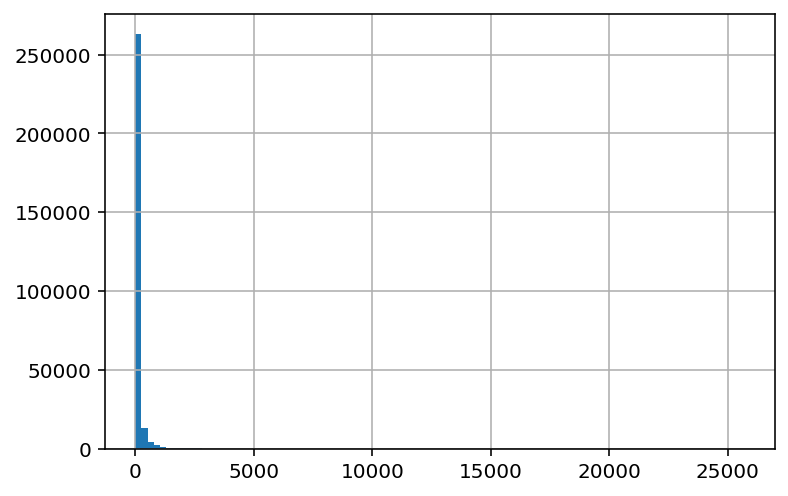

In [80]:
card_df['Amount'].hist(bins=100)

<AxesSubplot:>

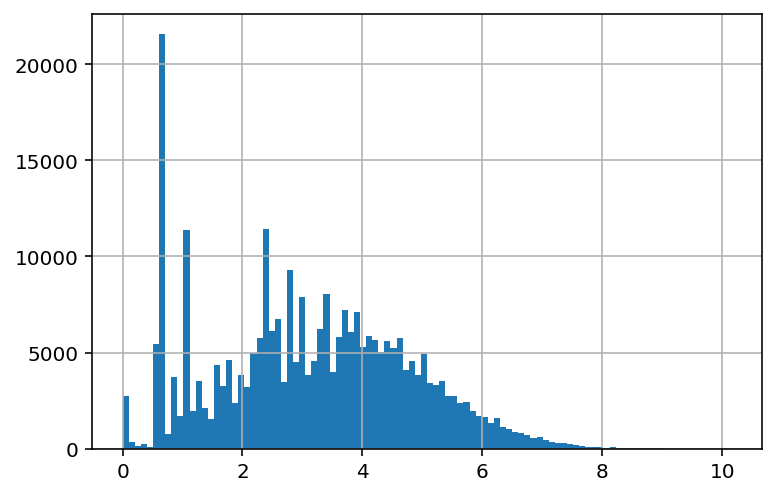

In [81]:
amount_log = np.log(1+card_df['Amount'])
amount_log.hist(bins=100)

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
amount_sc = scaler.fit_transform(amount_log.values.reshape(-1,1))

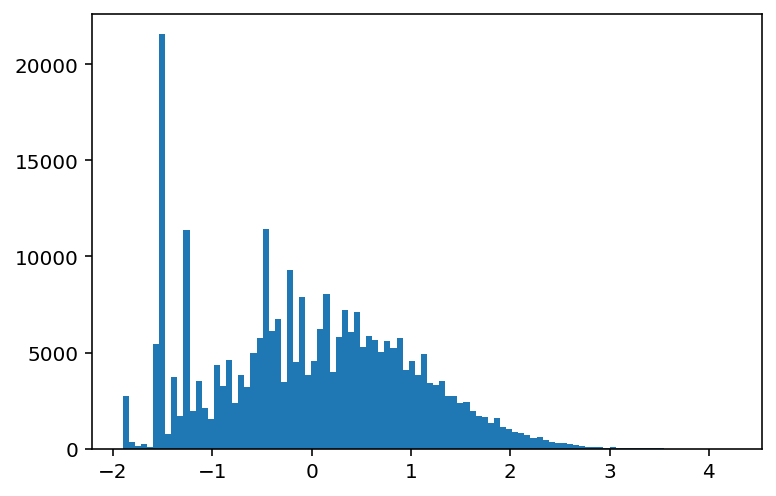

In [11]:
plt.hist(amount_sc, bins=100)
plt.show()

- 로그변환, 스케일링된 Amount를 사용한다
- df_sc로 대체

In [83]:
df_sc = card_df.copy()
df_sc['Amount'] = amount_sc
df_sc[:3]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.124303,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-1.114639,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.682368,0


## 훈련 데이터, 검증 데이터 나누기
### 계층적 샘플링
- 'Class' 컬럼이 목적변수(y)이다
- y의 분포에 맞게 훈련/검증 데이터 비율을 맞춘다: 계층적(stratified) 샘플링

In [87]:
X = df_sc.copy()
y = X.pop('Class')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                            random_state=9, stratify=y)

## (연습) 훈련/검증 데이터중 카드 도용 비율을 확인하시오
- 계층적 샘플링이 잘 수행되었는지 확인

In [136]:
# (풀이)



# 이진 분류

In [15]:
def show_clf_result(y_test, y_pred):
  print(confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))

def draw_roc(y_test, score):
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  fpr, tpr, _ = roc_curve(y_test, score)
  roc_auc = roc_auc_score(y_test, score)
  plt.figure(figsize=(6,6))
  plt.plot(fpr, tpr, label='AUC = %0.4f)' % roc_auc)
  plt.plot([0, 1], [0, 1], linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")

- 실험 결과 담는 리스트

In [90]:
result = []

## 로지스틱 회귀

In [91]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_test)
show_clf_result(y_test, y_pred)

[[71075     4]
 [   54    69]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.95      0.56      0.70       123

    accuracy                           1.00     71202
   macro avg       0.97      0.78      0.85     71202
weighted avg       1.00      1.00      1.00     71202



In [92]:
result.append(('logistic-regression',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976)]

### ROC
- 먼저 분류 확률 (또는 점수)를 구한다

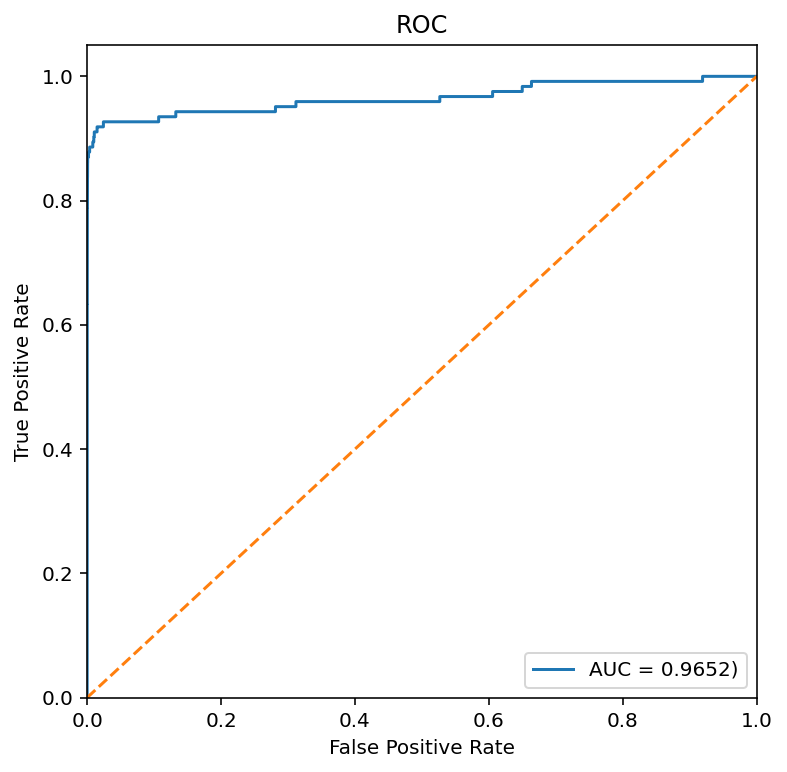

In [94]:
proba_1 = lr_clf.predict_proba(X_test)[:,1]
draw_roc(y_test, proba_1)

In [101]:
Z = pd.DataFrame(np.vstack((y_test.values, y_pred, proba_1)).T, 
                 columns=['y_test','y_pred','proba_1'])
Z[:3]

,y_test,y_pred,proba_1
0,0.0,0.0,0.000103
1,0.0,0.0,0.000095
2,0.0,0.0,0.000562


- 점수가 높은 순으로 (1이라고 판단할 점수) 임의로 N=200개만 그려보겠다

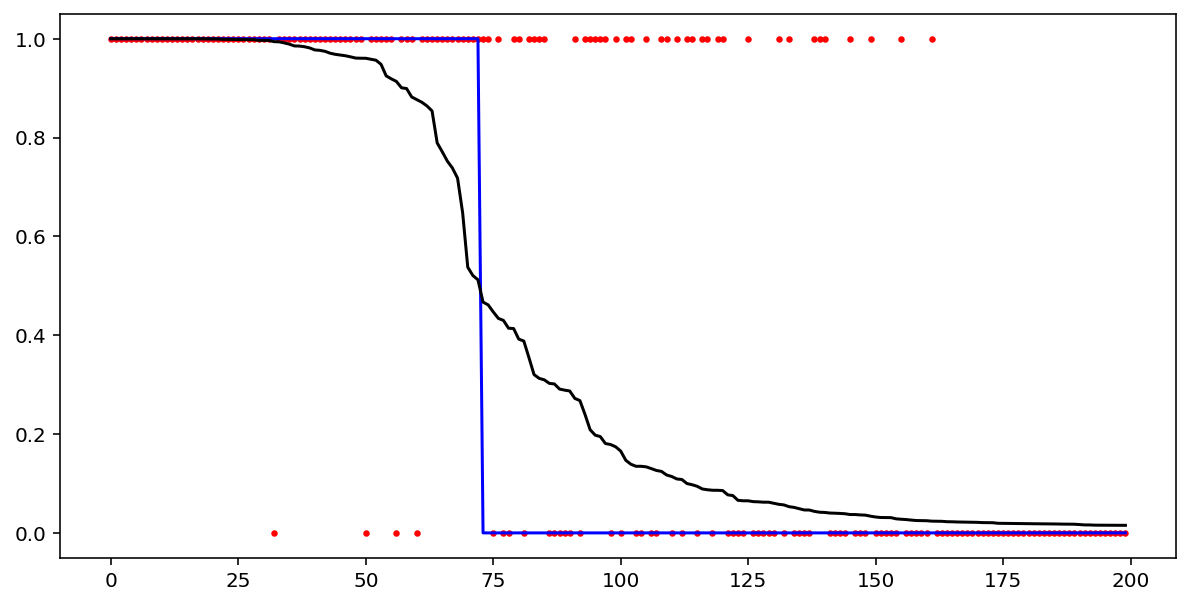

In [130]:
N = 200
Z = Z.sort_values(by=['proba_1'], ascending=False)
plt.figure(figsize=(10,5))
plt.scatter(range(N), Z['y_test'].values[:N], c='r', s=5)
plt.plot(Z['y_pred'].values[:N], c='b')
plt.plot(Z['proba_1'].values[:N], c='k')

## 랜덤 포레스트

In [103]:
rfc = RandomForestClassifier(n_estimators=30)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
result.append(('random-forest',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976),
 ('random-forest', 0.9894736842105263, 0.7642276422764228)]

- 1에 대한 리콜이 77%로 올라갔다

## LightGBM
- 불균형 데이터로 학습하려면 반드시 boost_from_average=False로 설정해야 한다

In [104]:
lgbm_clf = LGBMClassifier(n_estimators=100,boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
result.append(('lightgbm',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976),
 ('random-forest', 0.9894736842105263, 0.7642276422764228),
 ('lightgbm', 0.9509803921568627, 0.7886178861788617)]

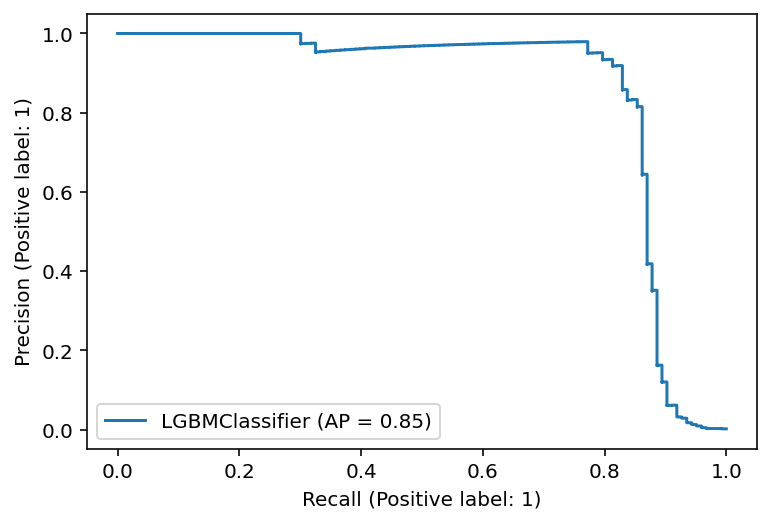

In [105]:
plot_precision_recall_curve(lgbm_clf, X_test, y_test)

## MLP 신경망

- tensorflow, keras 설치 필요
- colab에서 실행

In [ ]:
# 신경망 라이브러리
# import keras
# from keras.models import Sequential
# from keras.layers import Dense

# classifier = Sequential()
# classifier.add(Dense(units = 30 , activation = 'relu', input_dim = 29))
# classifier.add(Dense(30, activation = 'relu'))
# classifier.add(Dense(1, activation = 'sigmoid'))

# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# history = classifier.fit(X_train, y_train, batch_size=20, epochs=5,
#                   validation_split=0.2, verbose=1)

# # callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)])

In [ ]:
# MLP는 predict함수가 확률을 리턴한다
# y_pred_p = classifier.predict(X_test)
# y_pred = (y_pred_p.ravel() > 0.5)

# show_clf_result(y_test, y_pred)

# 데이터 불균형
- 데이터 불균형으로 분류 성능이 떨어진다
- 오버샘플링을 하여 적게 발생하는 데이터를 증식한다 (언더 샘플링은 작은 수에 맞추는 것)
- SMOTE(Synthetic Minority Over sampling Technique)
 - k 인접 샘플을 찾아서 사이의 값들을 추가로 사용한다
- SMOTE 오버 샘플링은 학습 데이터에만 적용해야 한다 (검증시에는 원본 데이터만 사용)
- 범주형이 있을 때는 SMOTE-NC (Nomincal and Continuous)를 사용한다
 - (참고) SMOTENC(categorical_features=[18, 19]))
- RandomOverSamling, Adaptive Synthetic Sampling 등도 사용한다

## SMOTE

In [106]:
X_train.shape, y_train.shape

((213605, 29), (213605,))

In [107]:
(y_train == 1).sum(),(y_train == 0).sum()

(369, 213236)

In [108]:
(y_train == 1).mean().round(5),(y_train == 0).mean().round(5)

(0.00173, 0.99827)

- 데이터 증식

In [31]:
smote = SMOTE(random_state=9)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
X_train_over.shape, y_train_over.shape

((426472, 29), (426472,))

- 0과 1의 갯수를 큰 쪽에 맞추어 오버샘플링한다

In [32]:
np.unique(y_train_over, return_counts=True)

(array([0, 1]), array([213236, 213236]))

- 학습만 오버 샘플로 수행하고
- 검증은 원래의 데이터로 수행해야 한다 (X_test, y_test 사용)

In [109]:
lr_clf = LogisticRegression()
lr_clf.fit(X_train_over, y_train_over)
y_pred = lr_clf.predict(X_test)
result.append(('log-reg-SMOTE',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976),
 ('random-forest', 0.9894736842105263, 0.7642276422764228),
 ('lightgbm', 0.9509803921568627, 0.7886178861788617),
 ('log-reg-SMOTE', 0.06172839506172839, 0.9349593495934959)]

- 1에 대한 리콜이 크게 향상되었지만 정밀도는 떨어진 것을 알 수 있다

In [110]:
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
result.append(('lgbm-SMOTE',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976),
 ('random-forest', 0.9894736842105263, 0.7642276422764228),
 ('lightgbm', 0.9509803921568627, 0.7886178861788617),
 ('log-reg-SMOTE', 0.06172839506172839, 0.9349593495934959),
 ('lgbm-SMOTE', 0.8869565217391304, 0.8292682926829268)]

## RandomOverSampler

In [111]:
ros = RandomOverSampler(random_state=9)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
result.append(('lgbm-RandomOverSampler',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976),
 ('random-forest', 0.9894736842105263, 0.7642276422764228),
 ('lightgbm', 0.9509803921568627, 0.7886178861788617),
 ('log-reg-SMOTE', 0.06172839506172839, 0.9349593495934959),
 ('lgbm-SMOTE', 0.8869565217391304, 0.8292682926829268),
 ('lgbm-RandomOverSampler', 0.9035087719298246, 0.8373983739837398)]

## ADASYN (Adaptive Synthetic Sampling)

In [112]:
adasyn = ADASYN(random_state=9)
X_train_over, y_train_over = adasyn.fit_resample(X_train, y_train)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
result.append(('lgbm-ADASYN',
    precision_score(y_test, y_pred), recall_score(y_test, y_pred)))
result

[('logistic-regression', 0.9452054794520548, 0.5609756097560976),
 ('random-forest', 0.9894736842105263, 0.7642276422764228),
 ('lightgbm', 0.9509803921568627, 0.7886178861788617),
 ('log-reg-SMOTE', 0.06172839506172839, 0.9349593495934959),
 ('lgbm-SMOTE', 0.8869565217391304, 0.8292682926829268),
 ('lgbm-RandomOverSampler', 0.9035087719298246, 0.8373983739837398),
 ('lgbm-ADASYN', 0.37943262411347517, 0.8699186991869918)]

## (연습) 위에서 구한 result 결과를 막대 그래프로 그리시오
- 각 모델에 대한 성능을 정밀도와 리콜 값으로 그리시오

In [137]:
# (풀이)



## 최적 샘플링 찾기

- sampling_strategy를 사용하여 증식하는 비율을 조정한다 (1이면 동수로 증식)

### 30% 만 증식

In [116]:
ros = RandomOverSampler(random_state=9, sampling_strategy=0.3)
X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
lgbm_clf.fit(X_train_over, y_train_over)
y_pred = lgbm_clf.predict(X_test)
precision_score(y_test, y_pred), recall_score(y_test, y_pred)

(0.9369369369369369, 0.8455284552845529)

In [117]:
X_train_over.shape

(277206, 29)

In [118]:
(y_train_over == 1).sum(),(y_train_over == 0).sum()

(63970, 213236)

In [119]:
show_clf_result(y_test, y_pred)

[[71072     7]
 [   19   104]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     71079
           1       0.94      0.85      0.89       123

    accuracy                           1.00     71202
   macro avg       0.97      0.92      0.94     71202
weighted avg       1.00      1.00      1.00     71202



## (연습) 최적의 sampling_strategy를 구하시오
- fraction 값을 0.01 ~ 1 사이에서 변화 시키면서 리콜과 정밀도가 높은 지점을 찾는다

### (힌트) 현재는 카드도용 비율이 0.17% 임. 이를 1% ~ 99% 범위에서 증식을 해보고 가장 성능이 좋은 증식 비율을 찾으시오
- 위의 예는 30% 증식한 사례임
- 결과를 리스트에 담고, 테이블이나 그래프로 그려서 비교하시오
- 최종 모델을 선정한 후(fraction ?), 이 모델을 사용해서 high_recall 또는 high_prec 모델을 만들면 
- **로지스틱 리그레션 모델보다 전체적으로 성능이 향상된** (랭킹 평가를 잘하는 proba_1을 사용하는) 모델을 얻게 된다.
- 이를 확인하기 위해서 Z 그래프를 그려보시오 (파란색 예측경계선 좌우의 오분류 샘플 수가 적어지는 것을 확인)
- 가장 높은 f-1 점수는?




# 정답

## (연습) 훈련/검증 데이터중 카드 도용 비율을 확인하시오
- 계층적 샘플링이 잘 수행되었는지 확인

In [128]:
y_train.value_counts(), y_test.value_counts()

(0    213236
 1       369
 Name: Class, dtype: int64,
 0    71079
 1      123
 Name: Class, dtype: int64)

In [127]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.998273
 1    0.001727
 Name: Class, dtype: float64,
 0    0.998273
 1    0.001727
 Name: Class, dtype: float64)

## (연습) 위에서 구한 result 결과를 막대 그래프로 그리시오
- 각 모델에 대한 성능을 정밀도와 리콜 값으로 그리시오

In [113]:
df = pd.DataFrame(result)
df.columns = ['model','precison', 'recall']
df.set_index('model', inplace=True)
df

,precison,recall
model,,
logistic-regression,0.945205,0.560976
random-forest,0.989474,0.764228
lightgbm,0.950980,0.788618
log-reg-SMOTE,0.061728,0.934959
lgbm-SMOTE,0.886957,0.829268
lgbm-RandomOverSampler,0.903509,0.837398
lgbm-ADASYN,0.379433,0.869919


<AxesSubplot:xlabel='model'>

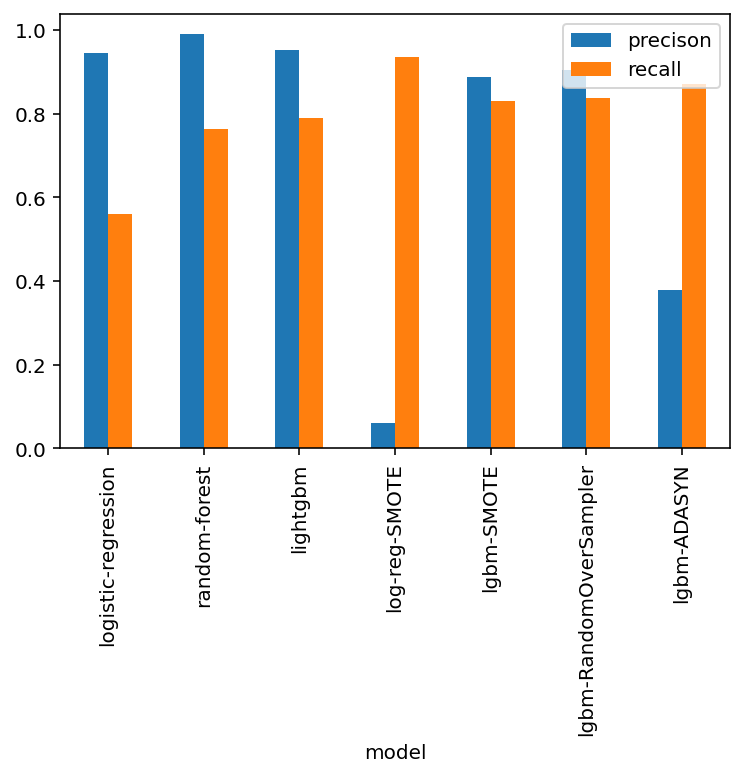

In [114]:
df.plot.bar()

## (연습) 최적의 sampling_strategy를 구하시오
- fraction 값을 0.01 ~ 1 사이에서 변화 시키면서 리콜과 정밀도가 높은 지점을 찾는다

<AxesSubplot:xlabel='fraction'>

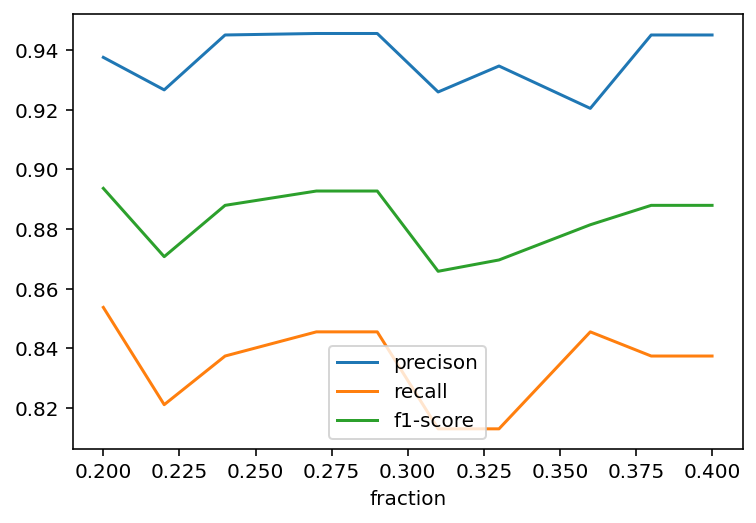

In [126]:
res_pr = []
for fraction in np.linspace(0.2,0.4,10).round(2):
    ros = RandomOverSampler(random_state=91, sampling_strategy=fraction)
    X_train_over, y_train_over = ros.fit_resample(X_train, y_train)
    lgbm_clf.fit(X_train_over, y_train_over)
    y_pred = lgbm_clf.predict(X_test)
    res_pr.append((fraction, precision_score(y_test, y_pred).round(4), 
          recall_score(y_test, y_pred).round(4), f1_score(y_test, y_pred).round(4)))

df1 = pd.DataFrame(res_pr)
df1.columns = ['fraction','precison', 'recall', 'f1-score']
df1.set_index('fraction', inplace=True)
df1.plot()

In [127]:
df1['f1-score'].max()

0.8936